In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to 'measurement' table
Measurement = Base.classes.measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Save references to 'station' table
Station = Base.classes.station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session (engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0] # converting last_date to str type
print(f'Last date in database: {last_date}')

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(last_date,"%Y-%m-%d").date() - dt.timedelta(days = 365)
print(f'Last year start date: {year_ago}')

# Perform a query to retrieve the data and precipitation scores
one_year = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date >= year_ago)\
                    .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(one_year, columns = ['date', 'precipitation'])
df_prcp = df_prcp.set_index('date')

# Sort the dataframe by date
df_prcp = df_prcp.sort_values('date')
df_prcp

Last date in database: 2017-08-23
Last year start date: 2016-08-23


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


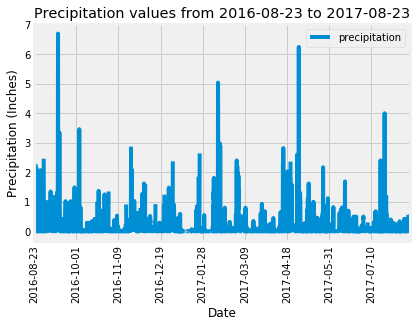

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df_prcp.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title(f'Precipitation values from {year_ago} to {last_date}')
plt.savefig('Output/precipitation_distibution.png', bbox_inches='tight')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = session.query(Measurement.station, func.count(Measurement.station))\
        .group_by(Measurement.station)\
        .order_by(func.count(Measurement.station).desc())

query.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = query.first()[0]
print(f'Most active station is: {most_active}')

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

session.query(*sel).filter(Measurement.station == most_active).all()

Most active station is: USC00519281


[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs)\
            .filter(Measurement.station == most_active)\
            .filter(Measurement.date >= year_ago)\
            .all()

df_tobs = pd.DataFrame(results, columns=['tobs'])
df_tobs

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


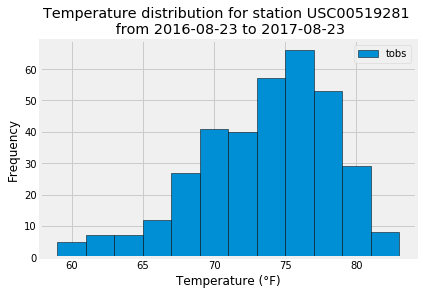

In [19]:
df_tobs.plot.hist(bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.title(f'Temperature distribution for station {most_active} \n from {year_ago} to {last_date}')
plt.savefig('Output/temperature_distribution.png', bbox_inches='tight')

## Additional Analysis

### Temperature Analysis I
Is there a meaningful difference between the temperature in, for example, June and December?

In [20]:
from scipy import stats
from scipy import mean

In [21]:
june_temp = session.query(Measurement.tobs)\
            .filter(func.strftime('%m', Measurement.date) == '06')\
            .all()

june_temp = list(np.ravel(june_temp))
print('Average temp in June: ',round(mean(june_temp),2))

Average temp in June:  74.94


In [22]:
dec_temp = session.query(Measurement.tobs)\
            .filter(func.strftime('%m', Measurement.date) == '12')\
            .all()

dec_temp = list(np.ravel(dec_temp))
print('Average temp in Dec: ',round(mean(dec_temp),2))

Average temp in Dec:  71.04


Null Hypothesis: There is no significant difference between the mean temperatures in June and December.
Alternate Hypothesis: Mean Temperature is June is significantly different from the mean temperature in December.

Using Independent t-test (unpaired test) as we are comparing the means of two independent groups.

In [23]:
stats.ttest_ind(june_temp, dec_temp, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

Assuming a 5% significance level, we reject the Null Hypothesis as pvalue < 0.05

### Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Trip dates '2020-08-01' to '2020-08-10'
# Database had data till '2017-08-23'

result = calc_temps('2017-08-01', '2017-08-10')
result

[(71.0, 79.02564102564102, 83.0)]

[71.0, 79.02564102564102, 83.0]


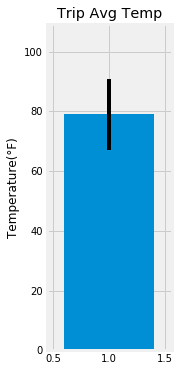

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp = list(np.ravel(result))
print(temp)
yerr = temp[2] - temp[0]

# Use the average temperature for the y value
fig, ax = plt.subplots(figsize=(2,6))
xpos = 1
ax.bar(xpos, temp[1], yerr=yerr)
ax.margins(.2,.2)
plt.ylabel('Temperature(°F)')
plt.title('Trip Avg Temp')
plt.savefig('Output/Trip Avg Temp.png',bbox_inches='tight')
plt.show()

### Daily Rainfall Average

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Measurement.station, Station.name, Station.latitude,
            Station.longitude, Station.elevation, func.sum(Measurement.prcp))\
            .filter(Measurement.station == Station.station)\
            .filter(Measurement.date >= '2017-08-01').filter(Measurement.date <= '2017-08-10')\
            .group_by(Measurement.station)\
            .order_by(func.sum(Measurement.prcp).desc())\
            .all()

for result in results:
    print(result)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.9199999999999999)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.32)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tavg, and tmax for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start = '2020-08-01'
trip_end = '2020-08-10'

# Use the start and end date to create a range of dates
date_list = pd.date_range(trip_start, trip_end)
date_list = date_list.astype(str)

# Stip off the year and save a list of %m-%d strings
date_list_month_day = [dates[5:] for dates in date_list]
date_list_month_day

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_list_month_day:
    normals.append(daily_normals(date)[0])

normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
trip_df['tavg']=trip_df['tavg'].round(1)
trip_df['date'] = date_list
trip_df.set_index('date', inplace=True)
trip_df

,tmin,tavg,tmax
date,,,
2020-08-01,67.0,75.5,83.0
2020-08-02,68.0,75.6,84.0
2020-08-03,70.0,76.6,85.0
2020-08-04,69.0,76.7,84.0
2020-08-05,69.0,76.1,82.0
2020-08-06,67.0,76.2,83.0
2020-08-07,71.0,77.2,83.0
2020-08-08,68.0,76.6,83.0
2020-08-09,69.0,76.0,81.0


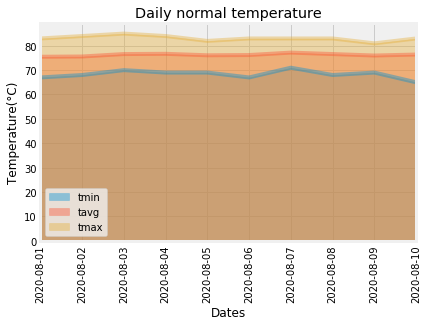

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
area1 = trip_df.plot.area(stacked=False, alpha=0.4)
plt.xlabel('Dates')
plt.ylabel('Temperature(°C)')
plt.title('Daily normal temperature')
area1.set_xticklabels(date_list,rotation=90)
plt.savefig('Output/Daily_Normal_Temperature.png',bbox_inches='tight')
plt.show()

In [32]:
session.close()